In [33]:

import rosbag_pandas.src.rosbag_pandas
import torch
import rosbag
import yaml
import os
import numpy as np
import torch
import pandas as pd

import skimage
import PIL
import torchvision
import cv2

import math

import glob

from matplotlib import pyplot as plt
import natsort

from scipy.spatial.transform import Rotation as R

%matplotlib inline


In [34]:
bag_path_root = '~/datasets/contact'
bag_path_root = os.path.expanduser(bag_path_root)
bag_path_root
bag_name = 'contact_dset_test_2022-07-13-14-17-57.bag'
bag_path = os.path.join(bag_path_root, bag_name)
os.path.exists(bag_path)
if not os.path.exists(bag_path):
    os.mkdir(bag_path)

In [82]:
bag = rosbag.Bag(bag_path, "r")
info_dict = yaml.safe_load(bag._get_yaml_info())

print(info_dict.keys())
info_dict['topics']
for topic_dict in info_dict['topics']:
    print(topic_dict)
    if 'contact_data' in topic_dict['topic']:
        contact_freq = topic_dict['frequency']
    elif 'franka_states' in topic_dict['topic']:
        print(topic_dict['messages'])

# contact_freq
contact_dt = 1./contact_freq
contact_dt


dict_keys(['path', 'version', 'duration', 'start', 'end', 'size', 'messages', 'indexed', 'compression', 'types', 'topics'])
{'topic': '/camera/color/image_raw/compressed', 'type': 'sensor_msgs/CompressedImage', 'messages': 311, 'frequency': 33.3333}
{'topic': '/camera/depth/image_raw/compressed', 'type': 'sensor_msgs/CompressedImage', 'messages': 311, 'frequency': 33.3333}
{'topic': '/clock', 'type': 'rosgraph_msgs/Clock', 'messages': 10389, 'frequency': 1000.0}
{'topic': '/contact_data_throttled', 'type': 'gazebo_msgs/ContactState', 'messages': 754, 'frequency': 83.3333}
{'topic': '/contact_time_throttled', 'type': 'std_msgs/Time', 'messages': 754, 'frequency': 83.3333}
{'topic': '/panda/franka_state_controller_custom/franka_states', 'type': 'franka_msgs/FrankaStateCustom', 'messages': 305, 'frequency': 29.4118}
305
{'topic': '/panda/franka_state_controller_custom/joint_states', 'type': 'sensor_msgs/JointState', 'messages': 305, 'frequency': 29.4118}
{'topic': '/panda/hybrid_impedance

0.01200000480000192

In [36]:
im_type = 'depth'
im_path = os.path.join(bag_path.strip('.bag'), im_type)
assert os.path.exists(im_path), 'im_path does not exist!!'


In [37]:
depth_times = np.load(os.path.join(im_path, 'timestamps.npy'), allow_pickle=True)

In [38]:
depth_times[slice(1,5)]

array([5408.17, 5408.21, 5408.24, 5408.27])

In [39]:
def get_stupid_idxs(idx, window, centered = False): 
    # 0 centering meaning the window is centered at the idx
    # neg is left shift, pos is right shift
    if centered:
        d = window//2
        l = idx - d
        r = idx + d 
        if window%2 == 0: #tries to center but with right side one element shorter 
            r -= 1
        return slice(l, r + 1)
    else: 
        return slice(idx - window + 1, idx + 1)


In [40]:
def get_idxs(idx, window): 
    # 0 centering meaning the window is centered at the idx
    # neg is left shift, pos is right shift
    if centered:
        d = window//2
        l = idx - d
        r = idx + d 
        if window%2 == 0: #tries to center but with right side one element shorter 
            r -= 1
        return slice(l, r + 1)
    else: 
        return slice(idx - window + 1, idx + 1)

In [41]:
def get_extr_idxs(array, window, centered = False):
    d = window//2
    length = len(array)
    if centered:
        # idx >= window//2
        l = d
        if window%2 == 0:
            r = length - d
        else: 
            r = length - d - 1
    else:
        r = length - 1
        l = window - 1

    # return r - l + 1
    return (l ,r)

In [42]:
im_paths = natsort.natsorted(glob.glob(os.path.join(im_path, '*.png')))
# im_paths

In [43]:
im_transform = torchvision.transforms.ToTensor() 

In [44]:
images = skimage.io.imread_collection(im_paths[0:10])
resize = ((images[0].shape[1]), (images[0].shape[0]))
# resized_im = 
# ims_tensor = torch.stack([im_transform(img) for img in images])
ims_tensor = torch.stack([im_transform(cv2.resize(img, resize, interpolation=cv2.INTER_CUBIC)) for img in images])
ims_tensor.shape

torch.Size([10, 1, 720, 1280])

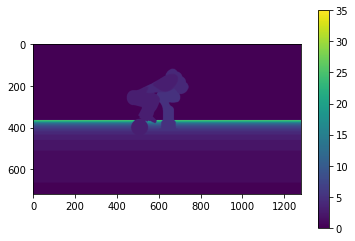

In [45]:
# plt.imshow(ims_tensor[0, :].permute(1, 2, 0))
plt.imshow(images[0])
plt.colorbar() 
plt.savefig(os.path.join(bag_path.strip('.bag'), 'orig_plt_fig.png'))

True

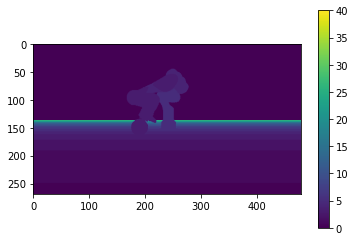

In [46]:
resize = ((images[0].shape[1]//8)*3, (images[0].shape[0]//8)*3)
resized_im = cv2.resize(images[0], resize, interpolation=cv2.INTER_LANCZOS4)
plt.imshow(resized_im)
plt.colorbar() 

cv2.imwrite(os.path.join(bag_path.strip('.bag'), 'lanczos.png'), cv2.applyColorMap(resized_im, cv2.COLORMAP_TURBO))



In [47]:
contact_df = rosbag_pandas.bag_to_dataframe(bag_path, include=['/contact_data_throttled'])
contact_df.to_pickle(os.path.join(bag_path.strip('.bag'), 'contact_df.pkl'))

In [48]:
contact_df.tail()

,/contact_data_throttled/collision1_name,/contact_data_throttled/collision2_name,/contact_data_throttled/contact_normals/0/x,/contact_data_throttled/contact_normals/0/y,/contact_data_throttled/contact_normals/0/z,/contact_data_throttled/contact_positions/0/x,/contact_data_throttled/contact_positions/0/y,/contact_data_throttled/contact_positions/0/z,/contact_data_throttled/depths/0,/contact_data_throttled/info,...,/contact_data_throttled/total_wrench/force/z,/contact_data_throttled/total_wrench/torque/x,/contact_data_throttled/total_wrench/torque/y,/contact_data_throttled/total_wrench/torque/z,/contact_data_throttled/wrenches/0/force/x,/contact_data_throttled/wrenches/0/force/y,/contact_data_throttled/wrenches/0/force/z,/contact_data_throttled/wrenches/0/torque/x,/contact_data_throttled/wrenches/0/torque/y,/contact_data_throttled/wrenches/0/torque/z
5416.827,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.580020,-0.158311,-4.698688e-07,4.698688e-07,,...,0.0,0.0,0.0,0.0,-1.225231,-0.384048,-6.939906,-0.004666,-0.255625,0.014970
5416.839,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.579179,-0.156607,-3.578719e-07,3.578719e-07,,...,0.0,0.0,0.0,0.0,-0.934704,-0.333967,-5.264105,0.002187,-0.194576,0.011956
5416.851,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.578229,-0.154964,-2.703976e-07,2.703976e-07,,...,0.0,0.0,0.0,0.0,-0.703064,-0.282144,-3.941462,0.005938,-0.146080,0.009398
5416.863,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.577170,-0.153407,-1.738955e-07,1.738955e-07,,...,0.0,0.0,0.0,0.0,-0.441486,-0.196754,-2.466550,0.006414,-0.091590,0.006158
5416.875,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.576007,-0.151951,-7.433589e-08,7.433589e-08,,...,0.0,0.0,0.0,0.0,-0.166067,-0.081439,-0.925751,0.003419,-0.034413,0.002414


In [49]:
proprio_df = rosbag_pandas.bag_to_dataframe(bag_path, include=['/panda/franka_state_controller_custom/franka_states'])
proprio_df.to_pickle(os.path.join(bag_path.strip('.bag'), 'proprio_df.pkl'))


In [50]:
base_topic = '/panda/franka_state_controller_custom/franka_states/'

In [90]:
pose_topics = []
for i in range(16):
    topic = base_topic + 'O_T_EE/' + str(i)
    pose_topics.append(topic)
# pose_topics
# '/panda/franka_state_controller_custom/franka_states/EE_T_K/0'


In [94]:
wrench_topics = []
for i in range(6):
    topic = base_topic + 'K_F_ext_hat_K/' + str(i)
    wrench_topics.append(topic)

In [52]:
torch.tensor(proprio_df.head()[pose_topics].values) # time x feature array

tensor([[-0.1198,  0.8841, -0.4517,  0.0000,  0.9829,  0.1697,  0.0714,  0.0000,
          0.1398, -0.4355, -0.8893,  0.0000,  0.5187, -0.1770,  0.1051,  1.0000],
        [-0.1513,  0.8800, -0.4503,  0.0000,  0.9773,  0.2014,  0.0652,  0.0000,
          0.1480, -0.4303, -0.8905,  0.0000,  0.5205, -0.1856,  0.1052,  1.0000],
        [-0.1863,  0.8741, -0.4485,  0.0000,  0.9697,  0.2370,  0.0591,  0.0000,
          0.1580, -0.4239, -0.8918,  0.0000,  0.5232, -0.1946,  0.1052,  1.0000],
        [-0.2237,  0.8664, -0.4464,  0.0000,  0.9599,  0.2752,  0.0531,  0.0000,
          0.1688, -0.4166, -0.8933,  0.0000,  0.5263, -0.2041,  0.1053,  1.0000],
        [-0.2617,  0.8569, -0.4442,  0.0000,  0.9483,  0.3139,  0.0469,  0.0000,
          0.1796, -0.4090, -0.8947,  0.0000,  0.5295, -0.2144,  0.1054,  1.0000]],
       dtype=torch.float64)

In [53]:
# torch.tensor(proprio_df.iloc[idx][pose_topics].values) # time x feature array

In [54]:
# np.array(proprio_df.iloc[idx][pose_topics].values) # time x feature array


In [55]:
# filter out collisions that arent of interest

df_filtered = contact_df.loc[(contact_df['/contact_data_throttled/collision1_name'].str.contains('sphere'))]
df_filtered.head()

,/contact_data_throttled/collision1_name,/contact_data_throttled/collision2_name,/contact_data_throttled/contact_normals/0/x,/contact_data_throttled/contact_normals/0/y,/contact_data_throttled/contact_normals/0/z,/contact_data_throttled/contact_positions/0/x,/contact_data_throttled/contact_positions/0/y,/contact_data_throttled/contact_positions/0/z,/contact_data_throttled/depths/0,/contact_data_throttled/info,...,/contact_data_throttled/total_wrench/force/z,/contact_data_throttled/total_wrench/torque/x,/contact_data_throttled/total_wrench/torque/y,/contact_data_throttled/total_wrench/torque/z,/contact_data_throttled/wrenches/0/force/x,/contact_data_throttled/wrenches/0/force/y,/contact_data_throttled/wrenches/0/force/z,/contact_data_throttled/wrenches/0/torque/x,/contact_data_throttled/wrenches/0/torque/y,/contact_data_throttled/wrenches/0/torque/z
5408.127,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.525100,-0.194739,-2.850095e-09,2.850095e-09,,...,0.0,0.0,0.0,0.0,-1.572832,-0.561263,-6.156867,0.077129,-0.093051,-0.011221
5408.138,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.525511,-0.197243,-3.048600e-09,3.048600e-09,,...,0.0,0.0,0.0,0.0,-1.447309,-0.521211,-5.714382,0.070955,-0.084947,-0.010223
5408.149,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.526002,-0.199800,-3.274787e-09,3.274787e-09,,...,0.0,0.0,0.0,0.0,-1.336133,-0.485193,-5.322442,0.065438,-0.077775,-0.009338
5408.160,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.526589,-0.202410,-3.536743e-09,3.536743e-09,,...,0.0,0.0,0.0,0.0,-1.238070,-0.452725,-4.976875,0.060502,-0.071443,-0.008552
5408.171,panda::panda_link7::panda_link7_fixed_joint_lu...,ground_plane::link::collision,0.0,0.0,1.0,0.527278,-0.205070,-3.799855e-09,3.799855e-09,,...,0.0,0.0,0.0,0.0,-1.150325,-0.422979,-4.667774,0.056018,-0.065774,-0.007845


In [131]:
def get_nearest_idxs(times, df_index):
    idxs = df_index.searchsorted(times, side="left")
    idxs_list = []
    if np.isscalar(times):
        times = [times]
    for i in range(len(times)):
        if idxs[i] > 0 and (idxs[i] == len(df_index) or math.fabs(times[i] - df_index[idxs[i]-1]) < math.fabs(times[i] - df_index[idxs[i]-1])):
            idxs_list.append(idxs[i]-1)
        else:
            idxs_list.append(idxs[i])
    return idxs_list

In [57]:
proprio_idxs = get_nearest_idxs(depth_times[0:20], proprio_df.index)
proprio_idxs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [133]:
contact_idxs = get_nearest_idxs(depth_times[0:5], df_filtered.index)
print(depth_times[0:5])
contact_idxs

[5408.14 5408.17 5408.21 5408.24 5408.27]


[2, 4, 8, 11, 13]

In [59]:
contact_df.iloc[contact_idxs]['/contact_data_throttled/collision1_name'].values

array(['panda::panda_link7::panda_link7_fixed_joint_lump__panda_sphere_collision_1',
       'panda::panda_link7::panda_link7_fixed_joint_lump__panda_sphere_collision_1',
       'panda::panda_link7::panda_link7_fixed_joint_lump__panda_sphere_collision_1',
       'panda::panda_link7::panda_link7_fixed_joint_lump__panda_sphere_collision_1',
       'panda::panda_link7::panda_link7_fixed_joint_lump__panda_sphere_collision_1'],
      dtype=object)

In [88]:
tf = proprio_df.iloc[proprio_idxs][pose_topics].values
tf
# np.reshape(tf, (4,4), order='F')

array([[-0.11977774,  0.88407564, -0.45173394,  0.        ,  0.98291187,
         0.16965905,  0.07141477,  0.        ,  0.13977681, -0.43546075,
        -0.88928982,  0.        ,  0.51865801, -0.17702047,  0.10509956,
         1.        ],
       [-0.15131782,  0.87995227, -0.45031869,  0.        ,  0.97733789,
         0.20140831,  0.06515621,  0.        ,  0.14803228, -0.43025422,
        -0.89048737,  0.        ,  0.52051377, -0.18560876,  0.10516998,
         1.        ],
       [-0.18633216,  0.87413308, -0.44852166,  0.        ,  0.96969646,
         0.23704717,  0.05913903,  0.        ,  0.15801617, -0.42391036,
        -0.89181326,  0.        ,  0.52318366, -0.19462077,  0.10524871,
         1.        ],
       [-0.22367416,  0.86643294, -0.44638978,  0.        ,  0.95993367,
         0.27515551,  0.05307344,  0.        ,  0.16881118, -0.41663342,
        -0.89326333,  0.        ,  0.52632084, -0.20413135,  0.10533382,
         1.        ],
       [-0.26166033,  0.85686942, -0

In [98]:
wrenches = proprio_df.iloc[proprio_idxs][wrench_topics].values
wrenches

array([[ 33.93949894,   6.46806685,  39.07649327,   9.79863008,
         -5.73515407,  -0.68926835],
       [ 33.47982987,   7.30875845,  40.89968537,  10.02757123,
         -5.16263336,  -0.64824303],
       [ 32.87674819,   8.75327988,  42.46436608,   9.87270887,
         -4.39154682,  -0.69922781],
       [ 32.92271688,  10.71413715,  43.01910923,   9.41958585,
         -3.56192459,  -0.88595418],
       [ 31.7795005 ,  11.93116962,  43.37322275,   9.16067963,
         -2.78925355,  -0.96870927],
       [ 28.66473668,  11.45134827,  44.79588726,   9.27317728,
         -1.9619585 ,  -0.78594501],
       [ 26.29902548,  11.74416833,  45.4569506 ,   8.79579998,
         -1.04810899,  -0.75041584],
       [ 23.58319953,  11.37675766,  46.72504021,   8.27706893,
         -0.1699076 ,  -0.69020176],
       [ 20.80384214,  10.55998071,  48.4548429 ,   7.55033667,
          0.65348161,  -0.62023169],
       [ 17.22144849,   8.19442431,  50.61850417,   6.88233306,
          1.51799267,  -0.4

In [61]:
def affine_tf_to_pose(tf):
        
        tf_np = np.reshape(tf, (4,4), order='F')
        # pose_np[0:4, 3]
        rot = tf_np[0:3, 0:3]
        # R @ R.T
        rot = R.from_matrix(rot)
        quat = rot.as_quat()
        quat = np.divide(quat, np.linalg.norm(quat))

        trans = tf_np[0:3, -1]
        pose = np.concatenate((trans, quat))
        return pose

In [62]:
def invert_transform(tf):
    R = tf[0:3, 0:3]
    T = tf[:3, -1]
    tf_inv = np.diag([0.,0.,0.,1.])
    tf_inv[:3, :3] = R.T
    tf_inv[:3, -1] = -R.T @ T
    return tf_inv

In [63]:
def transform_pose(pose_W, C_tf_W):
    C_rot_W = R.from_matrix(C_tf_W[:3, :3])

    pos = pose_W[:3]
    W_rot_EE = R.from_quat(pose_W[3:])
    pos_tfed = (C_tf_W @ np.concatenate((pos, np.array([1.,]))))[:-1]
    
    ori_tfed = C_rot_W * W_rot_EE

    return np.concatenate((pos_tfed, ori_tfed.as_quat())) 

In [145]:
def get_nearest_contact_idx(times, df_index, centered=False):
    if not centered:
        print(times[-1])
        return get_nearest_idxs([times[-1]], df_index)
    else:
        # print(times)
        print(len(times))
        print(times[len(times)//2])
        return get_nearest_idxs([times[len(times)//2]], df_index)


In [116]:
def get_contacts(times, contact_df):
    contact_list = []
    contact_times = []
    contact_time_diff = []
    for time in times:
        contacts = [] # list of all contact dicts at each timestep
        contact_idx = get_nearest_idxs([time], contact_df.index)[0]
        row = contact_df.iloc[contact_idx].loc[contact_df.iloc[contact_idx].notnull()]
        num_contacts = len(row[row.keys().str.contains('depths')])
        time_diff = abs(contact_df.index[contact_idx] - time)
        contact_time_diff.append(time_diff)
        if time_diff > (contact_dt*1.5):
            contact_list.append(None)
            contact_times.append(None)
        else:
            for contact_id in range(num_contacts):
                contact_dict = {}

                contact_pos_idx = '/contact_data_throttled/contact_positions/' + str(contact_id) 
                contact_pos_cols = [col for col in row.keys() if contact_pos_idx in col]
                contact_pos = np.array(row[contact_pos_cols].values)
                
                contact_dict['position'] = contact_pos

                contact_nrml_idx = '/contact_data_throttled/contact_normals/' + str(contact_id) 
                contact_nrml_cols = [col for col in row.keys() if contact_nrml_idx in col]
                contact_nrml = np.array(row[contact_nrml_cols].values)

                contact_dict['normal'] = contact_nrml

                contact_force_idx = '/contact_data_throttled/wrenches/' + str(contact_id) + '/force/'
                contact_force_cols = [col for col in row.keys() if contact_force_idx in col]
                contact_force = np.array(row[contact_force_cols].values)

                contact_dict['force'] = contact_force

                contact_torque_idx = '/contact_data_throttled/wrenches/' + str(contact_id) + '/torque/'
                contact_torque_cols = [col for col in row.keys() if contact_torque_idx in col]
                contact_torque = np.array(row[contact_torque_cols].values)

                contact_dict['torque'] = contact_torque
            
                contacts.append(contact_dict)
            
            contact_list.append(contacts)
            contact_times.append(contact_df.index[contact_idx])

    return contact_list, contact_times, contact_time_diff


In [223]:
contact_idx = get_nearest_contact_idx(depth_times[30:50], df_filtered.index, centered=False)
contact, times, time_diff = get_contacts(contact_idx, df_filtered)
print(contact_idx)
print(times)
print(contact_dt)
print(contact)

5409.77
[142]
[5409.648, 5409.672, 5409.718, 5409.742, 5409.778]
0.01200000480000192
1


In [114]:
test = depth_times[0:1]
for i in test:
    print(i)
# np.isscalar(depth_times[0])

5408.14


In [67]:
# contact, times = get_contacts([depth_times[0]], df_filtered)
# contact[0]

ValueError: too many values to unpack (expected 2)

# Projecting contact points into depth image

In [68]:
depth_tf_world = np.load(os.path.join(im_path, 'D_tf_W.npy'))
depth_tf_world
# W_tf_D

array([[ 1.59265291e-03,  9.99998732e-01,  0.00000000e+00,
         1.51110206e-02],
       [-4.89663865e-12,  7.60502772e-15, -1.00000000e+00,
         1.12500000e-01],
       [-9.99998732e-01,  1.59265291e-03,  4.89641661e-12,
         1.48939810e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [79]:
pose_idx = 4
# print(tf[pose_idx])
pose = affine_tf_to_pose(tf[pose_idx])
EE_rot = R.from_quat(pose[3:])
test_rot = R.from_euler('z', 90, degrees=True)
test_pose = np.concatenate((np.array([0,0,0]), test_rot.as_quat()))
test_tf = np.diag([1., 1., 1., 1.])
test_tf[:3, :3] = R.from_euler('z', 90, degrees=True).as_matrix()
print(test_tf) 
# print(EE_rot.as_euler('zyx', degrees=True))
depth_rot_world = R.from_matrix(depth_tf_world[:3, :3])
print(depth_rot_world.as_euler('xyz', degrees=True))
tfed_pose = transform_pose(test_pose, test_tf)
tfed_EE_rot = R.from_quat(tfed_pose[3:])
print(tfed_EE_rot.as_euler('xyz', degrees=True))


[[ 2.22044605e-16 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.22044605e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 8.99999998e+01  8.99087477e+01 -1.76148867e-07]
[  0.   0. 180.]


In [84]:
depth_K = np.load(os.path.join(im_path, 'depth_K.npy'))
# depth_K = np.array([462.1379699707031, 0.0, 320.0, 0.0, 462.1379699707031, 240.0, 0.0, 0.0, 1.0]).reshape((3,3))
# depth_K[:2, -1] = np.array([0,0])
depth_K

array([[695.99511719,   0.        , 640.        ],
       [  0.        , 695.99511719, 360.        ],
       [  0.        ,   0.        ,   1.        ]])

In [85]:
def point_proj(K, C_tf_W, pos):
    # R = W_tf_C[0:3, 0:3]
    # T = W_tf_C[:3, -1]
    # depth_tf_world = np.diag([0.,0.,0.,1.])
    # depth_tf_world[:3, :3] = R.T
    # depth_tf_world[:3, -1] = -R.T @ T
    # depth_tf_world = W_tf_C
    contact_pos_in_depth = (C_tf_W @ np.concatenate((pos, np.array([1]))))[:-1]
    # print(contact_pos_in_depth)
    project_coords = K @ (contact_pos_in_depth)
    return (project_coords[:2]/project_coords[-1]).astype(int)  



[524 365]
(720, 1280)


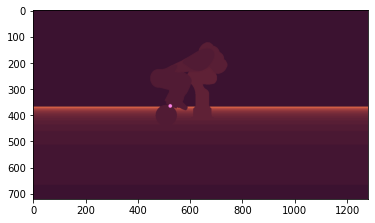

In [87]:
depth_idx = 0
proprio_idx = get_nearest_idxs([depth_times[depth_idx]], proprio_df.index)
proprio_df.iloc[proprio_idx[0]][pose_topics].values
pose = affine_tf_to_pose(proprio_df.iloc[proprio_idx[0]][pose_topics].values)
pose_prj = point_proj(depth_K, depth_tf_world, pose[:3])
print(pose_prj)
image = cv2.imread(im_paths[depth_idx])
print(image.shape[:2])
image = cv2.applyColorMap(image, cv2.COLORMAP_TURBO)
image = cv2.circle(image, tuple(pose_prj), radius=7, color=(255, 133, 233), thickness=-1)
plt.imshow(image)

311
[1.2349999999996726]
0.01200000480000192


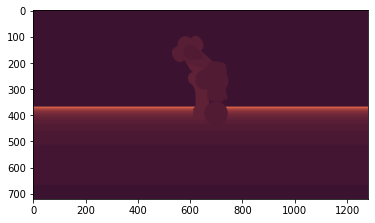

In [217]:
# image = skimage.io.imread(im_paths[depth_idx])
depth_idx = 299
print(len(depth_times))
contact, times, time_diffs = get_contacts([depth_times[depth_idx]], df_filtered)
print(time_diffs)
print(contact_dt)
if contact[0] == None:
    image = cv2.imread(im_paths[depth_idx])
    image = cv2.applyColorMap(image, cv2.COLORMAP_TURBO)
    plt.imshow(image)
else:
    contact_pos = contact[0][0]['position']
    # contact_pos = np.array([0.,0.6,0.3])
    # print(contact_pos)
    contact_pos_prj = point_proj(depth_K, depth_tf_world, contact_pos)
    print(contact_pos_prj)
    image = cv2.imread(im_paths[depth_idx])
    image = cv2.applyColorMap(image, cv2.COLORMAP_TURBO)
    image = cv2.circle(image, tuple(contact_pos_prj), radius=5, color=(255, 133, 233), thickness=-1)
    plt.imshow(image)
    # contact_pos


In [218]:
for c in contact:
    print(c)

None


(480, 270)
[499 409]
[186 153]


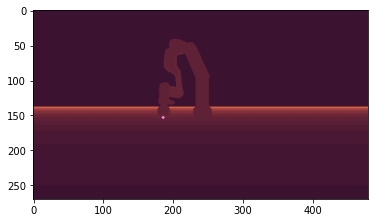

In [204]:
# image = skimage.io.imread(im_paths[depth_idx])
# print(len(depth_times))
contact, times, time_diffs = get_contacts([depth_times[depth_idx]], df_filtered)
# print(time_diffs)
# print(contact_dt)


# if contact[0] == None:
#     image = cv2.imread(im_paths[depth_idx])
#     image = cv2.applyColorMap(image, cv2.COLORMAP_TURBO)
#     plt.imshow(image)
# else:
contact_pos = contact[0][0]['position']
# contact_pos = np.array([0.,0.6,0.3])
# print(contact_pos)
contact_pos_prj = point_proj(depth_K, depth_tf_world, contact_pos)
# print(contact_pos_prj)
image = cv2.imread(im_paths[depth_idx])
resize = ((image.shape[1]//8)*3, (image.shape[0]//8)*3)
print(resize)
resized_im = cv2.resize(image, resize, interpolation=cv2.INTER_CUBIC)
image = cv2.applyColorMap(resized_im, cv2.COLORMAP_TURBO)
print(contact_pos_prj)
resized_contact_pos_prj = (contact_pos_prj//8)*3
print(resized_contact_pos_prj)
image = cv2.circle(image, tuple(resized_contact_pos_prj), radius=2, color=(255, 133, 233), thickness=-1)
plt.imshow(image)
# contact_pos

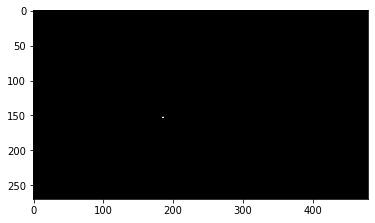

In [210]:
image = np.zeros((resize[1], resize[0]))
# resize = ((image.shape[1]//8)*3, (image.shape[0]//8)*3)
# print(resize)
# resized_im = cv2.resize(image, resize, interpolation=cv2.INTER_CUBIC)
# image = cv2.applyColorMap(resized_im, cv2.COLORMAP_TURBO)
# print(contact_pos_prj)
# resized_contact_pos_prj = (contact_pos_prj//8)*3
# print(resized_contact_pos_prj)
image[resized_contact_pos_prj[1], resized_contact_pos_prj[0]] = 1.
# image = cv2.circle(image, tuple(resized_contact_pos_prj), radius=2, color=(255, 133, 233), thickness=-1)
plt.imshow(image, cmap='gray', vmax=0.01)

In [214]:
(3,) + resize

(3, 480, 270)

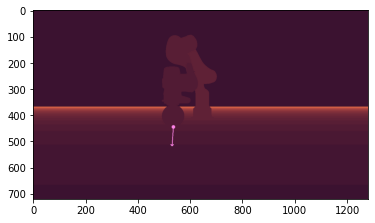

In [ ]:
contact_force = contact[0][0]['force']
force_mag = np.linalg.norm(contact_force)
force_endpt = contact_pos + 0.1*(contact_force/force_mag) 
force_endpt_prj = point_proj(depth_K, depth_tf_world, force_endpt)
image = cv2.arrowedLine(image, tuple(contact_pos_prj), tuple(force_endpt_prj), color=(255, 133, 233), thickness=2)
plt.imshow(image)


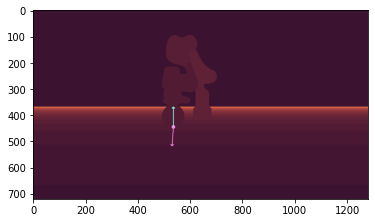

In [ ]:
contact_normal = contact[0][0]['normal']
normal_mag = np.linalg.norm(contact_normal)
normal_endpt = contact_pos + 0.1*(contact_normal/normal_mag) 
normal_endpt_prj = point_proj(depth_K, depth_tf_world, normal_endpt)
image = cv2.arrowedLine(image, tuple(contact_pos_prj), tuple(normal_endpt_prj), color=(133, 255, 233), thickness=2)
plt.imshow(image)